# Introduction to Data Science – Lecture 6: Loading Data, Dataframes
*COMP 5360/ MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecture, we will learn how to read in and write files and then finally cover pandas dataframes. 

# Pandas Series Recap

In the previous class we introduced pandas series, a one-dimensional data structure representing a data column. You will see that dataframes behave very similar to series, so we will only quickly recap the most important aspects.

Let's start by importing pandas.

In [94]:
import pandas as pd

Series have an index, and associated data. We can use the index to access the data. We've also learned that we can directly access indices and values through their implicit location. If we add the implicit location, a series looks like this: 


| Location (Implicit)| Index | Value | 
| - | - | - |
|0| Stones     |    1962
|1| Beatles    |    1960
|2| Zeppelin     |  1968
|3| Pink Floyd |    1965
|4| Pink Floyd |    2012

Here is the example in code:

In [95]:
bands_founded = pd.Series([1962, 1960, 1968, 1965, 2012],
                         name="founded",
                         index=["Stones", "Beatles", "Zeppelin", "Pink Floyd", "Pink Floyd"])
bands_founded

Stones        1962
Beatles       1960
Zeppelin      1968
Pink Floyd    1965
Pink Floyd    2012
Name: founded, dtype: int64

Notice that when we access data with multiple indices, we don't get a simple data type, as in the above cases, but instead get another series back:

In [96]:
bands_founded["Pink Floyd"]

Pink Floyd    1965
Pink Floyd    2012
Name: founded, dtype: int64

### Recap: Indexing and slicing

Indexing and slicing works largely like in normal python, but instead of just directly using the bracket notations, it is recommended to use `iloc` for indexing by position and `loc` for indexing by labelled indices. Accessing in such a way makes it easier to avoid confusing the index and the position.

In [97]:
# slicing by position
bands_founded.iloc[1:3]

Beatles     1960
Zeppelin    1968
Name: founded, dtype: int64

When slicing by labelled index, **the last value specified is** ***included***, which differs from regular Python slicing behavior.

In [98]:
# slicing by index
bands_founded.loc["Zeppelin" : "Pink Floyd"]

Zeppelin      1968
Pink Floyd    1965
Pink Floyd    2012
Name: founded, dtype: int64

Both, `iloc` and `loc` can be used with lists, which isn't possible in vanilla Python:

In [99]:
print(bands_founded.iloc[[0,3]])

Stones        1962
Pink Floyd    1965
Name: founded, dtype: int64


In [100]:
print(bands_founded.loc[["Beatles", "Pink Floyd"]])

Beatles       1960
Pink Floyd    1965
Pink Floyd    2012
Name: founded, dtype: int64


And, all these variants can also be used with boolean arrays, which we will soon find out to be very helpful:

In [101]:
bands_founded.loc[[True, False, False, True, False]]

Stones        1962
Pink Floyd    1965
Name: founded, dtype: int64

### Recap: Masking and Filtering

With pandas we can create boolean arrays that we can use to mask and filter a dataset. In the following expression, we'll create a new array that has "True" for every band formed after 1964:

In [102]:
mask = bands_founded > 1964
mask

Stones        False
Beatles       False
Zeppelin       True
Pink Floyd     True
Pink Floyd     True
Name: founded, dtype: bool

In [103]:
bands_founded[mask]

Zeppelin      1968
Pink Floyd    1965
Pink Floyd    2012
Name: founded, dtype: int64

In [104]:
bands_founded[bands_founded > 1964]

Zeppelin      1968
Pink Floyd    1965
Pink Floyd    2012
Name: founded, dtype: int64

## Recap/Catch up: Exploring a Series

There are various way we can explore a series. We can count the number of non-null values: 

In [105]:
numbers = pd.Series([1962, 1960, 1968, 1965, 2012, None, 2016])
numbers.count()

np.int64(6)

We can get the sum, mean, median of a series:

In [106]:
numbers.sum()

np.float64(11883.0)

In [107]:
numbers.mean()

np.float64(1980.5)

In [108]:
numbers.median()

1966.5

With `.describe()`, we can get an overview of the statistical properties of a series: 

In [109]:
numbers.describe()

count       6.000000
mean     1980.500000
std        26.120873
min      1960.000000
25%      1962.750000
50%      1966.500000
75%      2001.000000
max      2016.000000
dtype: float64

Note that None/NaN values are ignored here. We can drop all NaN values if we desire:

In [110]:
numbers = numbers.dropna()
numbers

0    1962.0
1    1960.0
2    1968.0
3    1965.0
4    2012.0
6    2016.0
dtype: float64

`.describe()` also works for non-numerical data. Of course, we get different measures:

In [111]:
bands = pd.Series(["Stones", "Beatles", "Zeppelin", "Pink Floyd"])
bands.describe()

count          4
unique         4
top       Stones
freq           1
dtype: object

Other useful methods are asking for a specific quantile, the minimum, the maximum, etc. 

In [112]:
numbers.quantile(0.25)

np.float64(1962.75)

In [113]:
numbers.max()

2016.0

In [114]:
numbers.min()

1960.0

## Recap/Catch up: Sorting 

We can sort a series by value or index:

In [115]:
numbers.sort_values() 

1    1960.0
0    1962.0
3    1965.0
2    1968.0
4    2012.0
6    2016.0
dtype: float64

And make the sorting descending: 

In [116]:
sorted_numbers = numbers.sort_index(ascending=False)
sorted_numbers

6    2016.0
4    2012.0
3    1965.0
2    1968.0
1    1960.0
0    1962.0
dtype: float64

Note that the indices remain the same! We can **reset the indices**:

In [117]:
# If we don't specify drop to be true, the previous indices are preserved in a separte column
new_sorted_numbers = sorted_numbers.reset_index(drop=True)
new_sorted_numbers

0    2016.0
1    2012.0
2    1965.0
3    1968.0
4    1960.0
5    1962.0
dtype: float64

We can also sort by the index:

In [118]:
# mix up the indices first
new_sorted_numbers = numbers.sort_values()
print(new_sorted_numbers)
new_sorted_numbers.sort_index()

1    1960.0
0    1962.0
3    1965.0
2    1968.0
4    2012.0
6    2016.0
dtype: float64


0    1962.0
1    1960.0
2    1968.0
3    1965.0
4    2012.0
6    2016.0
dtype: float64

## Applying a Function

Often, we will want to apply a function to all values of a Series. We can do that with the [`map()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html) function:

In [119]:
import datetime

# Convert an integer year into a date, assuming Jan 1 as day and month.
def to_date(year):
    return datetime.date(int(year), 1, 1)
    
new_sorted_numbers.map(to_date)

1    1960-01-01
0    1962-01-01
3    1965-01-01
2    1968-01-01
4    2012-01-01
6    2016-01-01
dtype: object

This is an incredibly powerful concept that you can use to modify series in sophisticated ways, similar to list comprehension. 

Another way to use the map function is to pass in a dictionary that is then applied to matching objects: 

In [120]:
new_sorted_numbers.map({1965:1945, 2012:1999, 1968:"What"})

1     NaN
0     NaN
3    1945
2    What
4    1999
6     NaN
dtype: object

Note how the unmapped rows are mapped to `NaN`.

# 1. Reading Data

Up to now, we've mainly used data that we've specified directly in code. This is, of course, not particularly scalable. We want to load data from files and eventually also connect to databases and APIs. 

Data is often stored in structured file formats, such as CSV, JSON, or XML. We'll encounter all of these file formats in this class.

JSON

```json
{
    "fruit": "Apple",
    "size": "Large",
    "color": "Red",
    "batches": [15, 17, 12],
    "producer": {
        name: Orchard
        founded: 1972
    }
}
```

XML
```xml
<note>
<to>Students</to>
<from>Prof</from>
<heading>Reminder</heading>
<body>HW2 due this Friday at 11:59pm!</body>
</note>
```

The simplest form is a **CSV (Comma Separated Values)** file. CSV isn't a formal file format, rather it's a table represented as a text file where the cells are separated by a <u>delimiter</u>. Commonly, the first row represents the header. A delimiter can be a tab character, a semicolon, a colon, etc. 

Many CSV files also have a special convention for dealing with text that could include the delimiter. The following text would be very hard to parse otherwise:
```
Artist, Album, Genre
Michael Jackson, Bad, Pop, Funk, Rock
``` 

Here, the album is of multiple genres which are separated by a comma. The comma, however, is also used to delimit the individual columns. 

To work around that, double-quotes are commonly used (though other escape characters are possible) to indicate that all the elements contained within the quotes are not meant to be delimiters:

```
Artist, Album, Genre
Michael Jackson, Bad, "Pop, Funk, Rock"
``` 

Of course, that's problematic if your text contains double-quotes. In that case, you'd have to *escape* them with a special character, such as a `\`. 

Now, it is clear that `Pop, Funk, Rock` should belong in a single cell. 

We've prepared a dataset based on Wikipedia's [list of best-selling albums](https://en.wikipedia.org/wiki/List_of_best-selling_albums) in the file [hit_albums.csv](./hit_albums.csv). 

Here is what the first couple of lines look like:

```
Artist,Album,Released,Genre,"Certified sales (millions)",Claimed sales (millions)
Michael Jackson,Thriller,1982,"Pop, rock, R&B",45.4,65
AC/DC,Back in Black,1980,Hard rock,25.9,50
Pink Floyd,The Dark Side of the Moon,1973,Progressive rock,22.7,45
Whitney Houston / Various artists,The Bodyguard,1992,"Soundtrack/R&B, soul, pop",27.4,44
...
```

There are various ways of reading a CSV file. We'll first cover the basic read (and write) operations of Python, but will quickly move on to specific parsers for CSV files in Python and in Pandas. 

## Basic File Operations

To read a file we first have to open it by specifying the file path, and specifying whether we want to read (r), write (w), both (r+), or append (a). 

In [121]:
albums_file = open('hit_albums.csv', 'r')

We can read a whole file at once. Notice that lines are terminated with a special character, a linefeed or newline character specified as `\n`.

In [122]:
content = albums_file.read()
content

'Artist,Album,Released,Genre,"Certified sales (millions)",Claimed sales (millions)\nMichael Jackson,Thriller,1982,"Pop, rock, R&B",45.4,65\nAC/DC,Back in Black,1980,Hard rock,25.9,50\nPink Floyd,The Dark Side of the Moon,1973,Progressive rock,22.7,45\nWhitney Houston / Various artists,The Bodyguard,1992,"Soundtrack/R&B, soul, pop",27.4,44\nMeat Loaf,Bat Out of Hell,1977,"Hard rock, progressive rock",20.6,43\nEagles,Their Greatest Hits (1971–1975),1976,"Rock, soft rock, folk rock",32.2,42\nBee Gees / Various artists,Saturday Night Fever,1977,Disco,19,40\nFleetwood Mac,Rumours,1977,Soft rock,27.9,40\nShania Twain,Come On Over,1997,"Country, pop",29.6,39\nLed Zeppelin,Led Zeppelin IV,1971,"Hard rock, heavy metal",29,37\nMichael Jackson,Bad,1987,"Pop, funk, rock",20.3,34\nAlanis Morissette,Jagged Little Pill,1995,Alternative rock,24.8,33\nCeline Dion,Falling into You,1996,"Pop, Soft rock",20.2,32\nThe Beatles,Sgt. Pepper\'s Lonely Hearts Club Band,1967,Rock,13.1,32\nEagles,Hotel California

If we print this instead, `\n` is translated into a newline: 

In [123]:
print(content)

Artist,Album,Released,Genre,"Certified sales (millions)",Claimed sales (millions)
Michael Jackson,Thriller,1982,"Pop, rock, R&B",45.4,65
AC/DC,Back in Black,1980,Hard rock,25.9,50
Pink Floyd,The Dark Side of the Moon,1973,Progressive rock,22.7,45
Whitney Houston / Various artists,The Bodyguard,1992,"Soundtrack/R&B, soul, pop",27.4,44
Meat Loaf,Bat Out of Hell,1977,"Hard rock, progressive rock",20.6,43
Eagles,Their Greatest Hits (1971–1975),1976,"Rock, soft rock, folk rock",32.2,42
Bee Gees / Various artists,Saturday Night Fever,1977,Disco,19,40
Fleetwood Mac,Rumours,1977,Soft rock,27.9,40
Shania Twain,Come On Over,1997,"Country, pop",29.6,39
Led Zeppelin,Led Zeppelin IV,1971,"Hard rock, heavy metal",29,37
Michael Jackson,Bad,1987,"Pop, funk, rock",20.3,34
Alanis Morissette,Jagged Little Pill,1995,Alternative rock,24.8,33
Celine Dion,Falling into You,1996,"Pop, Soft rock",20.2,32
The Beatles,Sgt. Pepper's Lonely Hearts Club Band,1967,Rock,13.1,32
Eagles,Hotel California,1976,"Rock, soft

After reading a file, we have to manually close it again to release the operating system resources:

In [124]:
albums_file.close()

As an alternative to reading the whole file, we can read each line separately:

In [125]:
albums_file = open('hit_albums.csv', 'r')
line1 = albums_file.readline();
print(line1)

Artist,Album,Released,Genre,"Certified sales (millions)",Claimed sales (millions)



We could now [`split()`](https://docs.python.org/3/library/stdtypes.html#str.split) the string based on the comma, to create a simple CSV parser:

In [126]:
line1.split(",")

['Artist',
 'Album',
 'Released',
 'Genre',
 '"Certified sales (millions)"',
 'Claimed sales (millions)\n']

After you have called  `readline()`, the next time you call it, it will read the next line. 

We can also treat `albums_file` as a list (or better, as an iterable data structure) and loop over the file and read the data into an list:

In [127]:
data = []
for line in albums_file:
    data.append(line.split(","))
    
# let's not forget to close the file:
albums_file.close()
data

[['Michael Jackson',
  'Thriller',
  '1982',
  '"Pop',
  ' rock',
  ' R&B"',
  '45.4',
  '65\n'],
 ['AC/DC', 'Back in Black', '1980', 'Hard rock', '25.9', '50\n'],
 ['Pink Floyd',
  'The Dark Side of the Moon',
  '1973',
  'Progressive rock',
  '22.7',
  '45\n'],
 ['Whitney Houston / Various artists',
  'The Bodyguard',
  '1992',
  '"Soundtrack/R&B',
  ' soul',
  ' pop"',
  '27.4',
  '44\n'],
 ['Meat Loaf',
  'Bat Out of Hell',
  '1977',
  '"Hard rock',
  ' progressive rock"',
  '20.6',
  '43\n'],
 ['Eagles',
  'Their Greatest Hits (1971–1975)',
  '1976',
  '"Rock',
  ' soft rock',
  ' folk rock"',
  '32.2',
  '42\n'],
 ['Bee Gees / Various artists',
  'Saturday Night Fever',
  '1977',
  'Disco',
  '19',
  '40\n'],
 ['Fleetwood Mac', 'Rumours', '1977', 'Soft rock', '27.9', '40\n'],
 ['Shania Twain', 'Come On Over', '1997', '"Country', ' pop"', '29.6', '39\n'],
 ['Led Zeppelin',
  'Led Zeppelin IV',
  '1971',
  '"Hard rock',
  ' heavy metal"',
  '29',
  '37\n'],
 ['Michael Jackson', 'Ba

We can now read individual cells or rows:

In [128]:
data[0]

['Michael Jackson',
 'Thriller',
 '1982',
 '"Pop',
 ' rock',
 ' R&B"',
 '45.4',
 '65\n']

In [129]:
data[0][1]

'Thriller'

As we can see, this **didn't take proper care of our double-quote escape of "Pop, rock, R&B"** and so they appear as different elements in the list! Also, numbers are still treated as strings and the newline character is also appended to the last cell. 

We could certainly improve our code to handle these issues, but fortunately, someone has already done this for us. There are several existing methods to parse CSV files which we will go over below.

### Writing

We can write by opening a file using the `w` flag. Here we also use the [`with`](https://docs.python.org/3/reference/compound_stmts.html#the-with-statement) keyword, which takes care of closing the file for us, even if things go wrong:

In [130]:
with open('my_file.txt', 'w') as new_file:
    new_file.write("Hello World\nAre you still spinning?\n")

We can now check out this file by opening [my_file.txt](my_file.txt). Notice that the file is only guaranteed to be written if you actually close it (which, here, is take care of by the context manager invoked by the `with` statement). 

You can find more examples on basic file operations in the [Python Documentation](https://docs.python.org/3/tutorial/inputoutput.html).

## Reading a CSV file with the CSV module

We can use the CSV module to help with reading the data. It takes a `delimiter` and a `quotechar` as parameters; the latter is useful for our double quotes:

In [131]:
# import the csv library
import csv

# initialize the top-level array
data_values = []

# open the file and append rows as arrays to the data_values
with open('hit_albums.csv') as csvfile:
    # note that we can interchangably use ' and " in general
    # for the quotechar, however we use ' so that we can use " without escaping
    filereader = csv.reader(csvfile, delimiter=',', quotechar='"')
    # the row here is an array
    for row in filereader:
        print("Row: " + str(row))
        data_values.append(row)

# Store the header in a separate array
header = data_values.pop(0)
   
print()    
print("Header is", header)

Row: ['Artist', 'Album', 'Released', 'Genre', 'Certified sales (millions)', 'Claimed sales (millions)']
Row: ['Michael Jackson', 'Thriller', '1982', 'Pop, rock, R&B', '45.4', '65']
Row: ['AC/DC', 'Back in Black', '1980', 'Hard rock', '25.9', '50']
Row: ['Pink Floyd', 'The Dark Side of the Moon', '1973', 'Progressive rock', '22.7', '45']
Row: ['Whitney Houston / Various artists', 'The Bodyguard', '1992', 'Soundtrack/R&B, soul, pop', '27.4', '44']
Row: ['Meat Loaf', 'Bat Out of Hell', '1977', 'Hard rock, progressive rock', '20.6', '43']
Row: ['Eagles', 'Their Greatest Hits (1971–1975)', '1976', 'Rock, soft rock, folk rock', '32.2', '42']
Row: ['Bee Gees / Various artists', 'Saturday Night Fever', '1977', 'Disco', '19', '40']
Row: ['Fleetwood Mac', 'Rumours', '1977', 'Soft rock', '27.9', '40']
Row: ['Shania Twain', 'Come On Over', '1997', 'Country, pop', '29.6', '39']
Row: ['Led Zeppelin', 'Led Zeppelin IV', '1971', 'Hard rock, heavy metal', '29', '37']
Row: ['Michael Jackson', 'Bad', '19

To do computation on the numerical dimensions of this table, we need to convert the strings to numbers. If we just do this the simple way, it won't work: 

In [132]:
for row in data_values: 
    row[2] = int(row[2])
    row[4] = float(row[4])
    #row[5] = float(row[5])
        
data_values

[['Michael Jackson', 'Thriller', 1982, 'Pop, rock, R&B', 45.4, '65'],
 ['AC/DC', 'Back in Black', 1980, 'Hard rock', 25.9, '50'],
 ['Pink Floyd',
  'The Dark Side of the Moon',
  1973,
  'Progressive rock',
  22.7,
  '45'],
 ['Whitney Houston / Various artists',
  'The Bodyguard',
  1992,
  'Soundtrack/R&B, soul, pop',
  27.4,
  '44'],
 ['Meat Loaf',
  'Bat Out of Hell',
  1977,
  'Hard rock, progressive rock',
  20.6,
  '43'],
 ['Eagles',
  'Their Greatest Hits (1971–1975)',
  1976,
  'Rock, soft rock, folk rock',
  32.2,
  '42'],
 ['Bee Gees / Various artists',
  'Saturday Night Fever',
  1977,
  'Disco',
  19.0,
  '40'],
 ['Fleetwood Mac', 'Rumours', 1977, 'Soft rock', 27.9, '40'],
 ['Shania Twain', 'Come On Over', 1997, 'Country, pop', 29.6, '39'],
 ['Led Zeppelin',
  'Led Zeppelin IV',
  1971,
  'Hard rock, heavy metal',
  29.0,
  '37'],
 ['Michael Jackson', 'Bad', 1987, 'Pop, funk, rock', 20.3, '34'],
 ['Alanis Morissette',
  'Jagged Little Pill',
  1995,
  'Alternative rock',
  

This is because the last column, `Claimed sales (millions)` doesn't have values for each row. In that case, the conversion throws the above `ValueError`. 

These errors are also called Exceptions. [Exceptions](https://docs.python.org/3/reference/compound_stmts.html#try) are error states that can be raised and caught:

In [133]:
for row in data_values: 
    # need to try and catch the exception because the column contains NaN values
    try:
        row[2] = int(row[2])
        row[4] = float(row[4])
        row[5] = float(row[5])
    except ValueError: 
        row[5] = None
    
data_values

[['Michael Jackson', 'Thriller', 1982, 'Pop, rock, R&B', 45.4, 65.0],
 ['AC/DC', 'Back in Black', 1980, 'Hard rock', 25.9, 50.0],
 ['Pink Floyd',
  'The Dark Side of the Moon',
  1973,
  'Progressive rock',
  22.7,
  45.0],
 ['Whitney Houston / Various artists',
  'The Bodyguard',
  1992,
  'Soundtrack/R&B, soul, pop',
  27.4,
  44.0],
 ['Meat Loaf',
  'Bat Out of Hell',
  1977,
  'Hard rock, progressive rock',
  20.6,
  43.0],
 ['Eagles',
  'Their Greatest Hits (1971–1975)',
  1976,
  'Rock, soft rock, folk rock',
  32.2,
  42.0],
 ['Bee Gees / Various artists',
  'Saturday Night Fever',
  1977,
  'Disco',
  19.0,
  40.0],
 ['Fleetwood Mac', 'Rumours', 1977, 'Soft rock', 27.9, 40.0],
 ['Shania Twain', 'Come On Over', 1997, 'Country, pop', 29.6, 39.0],
 ['Led Zeppelin',
  'Led Zeppelin IV',
  1971,
  'Hard rock, heavy metal',
  29.0,
  37.0],
 ['Michael Jackson', 'Bad', 1987, 'Pop, funk, rock', 20.3, 34.0],
 ['Alanis Morissette',
  'Jagged Little Pill',
  1995,
  'Alternative rock',
  

So, here we have matrix that we could work with. In reality, we probably would want to structure the data a little differently: 

Instead of treating each row as an array, we'd want to treat each dimension (column) as an array, as this is consistent with the rule of keeping the values of an array of the same type and makes the column homogeneous and it makes it easy to calculate means, etc. 

### Try it!
The file [grades.csv](grades.csv) is a file with student names and letter grades:

```
Alice; A
Bob; B
Robert; A
Richard; C
```

* Use the csv module to read in the file.
* Add a GPA to each student's row (A=4.0,B=3.0,C=2.0,D=1.0). 

Hint: the function [strip()](https://docs.python.org/3/library/stdtypes.html#str.strip) removes trailing whitespace from a string.

In [134]:
grades = []
gpadict = {"A":4.0,"B":3.0,"C":2.0,"D":1.0}
with open('grades.csv') as csvfile:
    filereader = csv.reader(csvfile, delimiter=';')

    for row in filereader:
        print("Row: " + str(row))
        row.append(gpadict[row[1].strip()])
        grades.append(row)

print(grades)

for row in grades:
    row[1] = row[1].strip()

print(grades)

Row: ['Alice', ' A']
Row: ['Bob', ' B']
Row: ['Robert', ' A']
Row: ['Richard', ' C']
[['Alice', ' A', 4.0], ['Bob', ' B', 3.0], ['Robert', ' A', 4.0], ['Richard', ' C', 2.0]]
[['Alice', 'A', 4.0], ['Bob', 'B', 3.0], ['Robert', 'A', 4.0], ['Richard', 'C', 2.0]]


## Reading CSV with Pandas

Now, let's take a look at what it takes to read this file using pandas.

In [135]:
hit_albums = pd.read_csv("hit_albums.csv")
hit_albums

,Artist,Album,Released,Genre,Certified sales (millions),Claimed sales (millions)
0,Michael Jackson,Thriller,1982,"Pop, rock, R&B",45.4,65.0
1,AC/DC,Back in Black,1980,Hard rock,25.9,50.0
2,Pink Floyd,The Dark Side of the Moon,1973,Progressive rock,22.7,45.0
3,Whitney Houston / Various artists,The Bodyguard,1992,"Soundtrack/R&B, soul, pop",27.4,44.0
4,Meat Loaf,Bat Out of Hell,1977,"Hard rock, progressive rock",20.6,43.0
...,...,...,...,...,...,...
72,Tracy Chapman,Tracy Chapman,1988,Folk rock,20.0,NaN
73,Usher,Confessions,2004,R&B,20.0,NaN
74,Various artists,Flashdance: Original Soundtrack from the Motio...,1983,Soundtrack,20.0,NaN
75,Whitney Houston,Whitney,1987,"Pop, R&B",20.0,NaN


In [136]:
grades = pd.read_csv("grades.csv", delimiter=';')
grades

,Alice,A
0,Bob,B
1,Robert,A
2,Richard,C


Well, that was different! 

Pandas provides the insanely powerful ['read_csv()'](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) method. Also see [the documentation](http://pandas.pydata.org/pandas-docs/stable/io.html) for more info on all I/O (input/output) operations in pandas, including writing CSV files. 

You can pass a lot of arguments to the method, such as delimiter, quote-chars, etc., but for our case the default parameters just worked. 

We've also just created our first data frame! Let's look at data frames in detail next. 

# 2. Data Frames

A data frame is a column-oriented data structure where each column is a pandas series.

Remember the [cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf) linked from the last lecture.

We've already loaded a data frame from file, but for completeness sake, let's create one in code: 

In [137]:
bandInfo = pd.DataFrame({
        "Name":["Led Zeppelin", "The Beatles", "Rolling Stones", "Radiohead"],
        "Num Members":[4, 4, 4, 5],
        "Num Albums":[9, 12, 29 ,9]
    })
bandInfo

,Name,Num Members,Num Albums
0,Led Zeppelin,4,9
1,The Beatles,4,12
2,Rolling Stones,4,29
3,Radiohead,5,9


This dataframe was initialized with a dictonary of column headers as keys and column data as values.

Just as a series, a data frame has an index, which corresponds to the first column here. In this case the index was automatically generated, but as for the series, we could use explicit values for the index. 

We can access columns in a data frame, which returns a series:

In [138]:
bandInfo["Name"]

0      Led Zeppelin
1       The Beatles
2    Rolling Stones
3         Radiohead
Name: Name, dtype: object

In [139]:
type(bandInfo["Name"])

pandas.core.series.Series

And obviously, we can do all the things we've learned about to this column/series. 

The previous example used columns to create the data frame. We can also create a data frame from rows. This doesn't make a ton of sense in this example, but data could be available like this from your data source, like if you're reading in from a CSV.

In [140]:
bandInfo2 = pd.DataFrame([
        {"Name":"Led Zeppelin", "No Albums":9, "No Members":4},
        {"Name":"The Beatles", "No Albums":12, "No Members":4},
        {"Name":"Rolling Stones", "No Albums":29, "No Members":4},
        {"Name":"Radiohead", "No Albums":9, "No Members":5},
    ])
bandInfo2

,Name,No Albums,No Members
0,Led Zeppelin,9,4
1,The Beatles,12,4
2,Rolling Stones,29,4
3,Radiohead,9,5


While a series has only one axis, a dataframe has two, one for the rows (the index or '0' axis), one for the columns (the column or '1' axis). We can check out these axes:

In [141]:
bandInfo.axes

[RangeIndex(start=0, stop=4, step=1),
 Index(['Name', 'Num Members', 'Num Albums'], dtype='object')]

We can access these axes directly:

In [142]:
# The row axis
bandInfo.axes[0]

RangeIndex(start=0, stop=4, step=1)

In [143]:
# The columns axis
bandInfo.axes[1]

Index(['Name', 'Num Members', 'Num Albums'], dtype='object')

## Exploring Data Frames

You might have noticed that data frames are rendered in pretty tables within Jupyter Notebooks. For small data frames, just showing all the data makes sense, but for larger datasets, like our `hit_albums` dataset, plotting 70+ rows can be annoying, and for datasets with hundreds or thousands of rows it can be prohibitive. By default, a data frame only prints a limited number of elements (notice the `...` of the output of `hit_albums` above – only the first and last few are printed. 

When working with data, e.g., when transforming or loading a dataset, it is important to see the raw data to, for example, check if a transformation was done correctly. Often, however, it's sufficient to see a part of the data, e.g., the first couple of rows and/or the last couple of rows. We can do this with the `head()` and `tail()` function:

In [144]:
# head shows the first 5 rows of a datset
hit_albums.head()

,Artist,Album,Released,Genre,Certified sales (millions),Claimed sales (millions)
0,Michael Jackson,Thriller,1982,"Pop, rock, R&B",45.4,65.0
1,AC/DC,Back in Black,1980,Hard rock,25.9,50.0
2,Pink Floyd,The Dark Side of the Moon,1973,Progressive rock,22.7,45.0
3,Whitney Houston / Various artists,The Bodyguard,1992,"Soundtrack/R&B, soul, pop",27.4,44.0
4,Meat Loaf,Bat Out of Hell,1977,"Hard rock, progressive rock",20.6,43.0


In [145]:
# we can specify how much to show
hit_albums.head(8)

,Artist,Album,Released,Genre,Certified sales (millions),Claimed sales (millions)
0,Michael Jackson,Thriller,1982,"Pop, rock, R&B",45.4,65.0
1,AC/DC,Back in Black,1980,Hard rock,25.9,50.0
2,Pink Floyd,The Dark Side of the Moon,1973,Progressive rock,22.7,45.0
3,Whitney Houston / Various artists,The Bodyguard,1992,"Soundtrack/R&B, soul, pop",27.4,44.0
4,Meat Loaf,Bat Out of Hell,1977,"Hard rock, progressive rock",20.6,43.0
5,Eagles,Their Greatest Hits (1971–1975),1976,"Rock, soft rock, folk rock",32.2,42.0
6,Bee Gees / Various artists,Saturday Night Fever,1977,Disco,19.0,40.0
7,Fleetwood Mac,Rumours,1977,Soft rock,27.9,40.0


In [146]:
# tail shows the last five rows in a datasaet
hit_albums.tail()

,Artist,Album,Released,Genre,Certified sales (millions),Claimed sales (millions)
72,Tracy Chapman,Tracy Chapman,1988,Folk rock,20.0,NaN
73,Usher,Confessions,2004,R&B,20.0,NaN
74,Various artists,Flashdance: Original Soundtrack from the Motio...,1983,Soundtrack,20.0,NaN
75,Whitney Houston,Whitney,1987,"Pop, R&B",20.0,NaN
76,Shakira,Laundry Service,2001,"Pop, Rock",20.0,NaN


Or, if we really want to see as many rows as possible, we can use this option: 

In [147]:
# we want to see all the rows
pd.set_option("display.max_rows", None)
hit_albums

,Artist,Album,Released,Genre,Certified sales (millions),Claimed sales (millions)
0,Michael Jackson,Thriller,1982,"Pop, rock, R&B",45.4,65.0
1,AC/DC,Back in Black,1980,Hard rock,25.9,50.0
2,Pink Floyd,The Dark Side of the Moon,1973,Progressive rock,22.7,45.0
3,Whitney Houston / Various artists,The Bodyguard,1992,"Soundtrack/R&B, soul, pop",27.4,44.0
4,Meat Loaf,Bat Out of Hell,1977,"Hard rock, progressive rock",20.6,43.0
5,Eagles,Their Greatest Hits (1971–1975),1976,"Rock, soft rock, folk rock",32.2,42.0
6,Bee Gees / Various artists,Saturday Night Fever,1977,Disco,19.0,40.0
7,Fleetwood Mac,Rumours,1977,Soft rock,27.9,40.0
8,Shania Twain,Come On Over,1997,"Country, pop",29.6,39.0
9,Led Zeppelin,Led Zeppelin IV,1971,"Hard rock, heavy metal",29.0,37.0


Be warned! This operation may take a lot of time if your dataset is large!

We can check out the dimensions of the data frame:

In [148]:
hit_albums.shape

(77, 6)

Here we learn that our dataset has 77 rows and 6 columns.

We can also get more info about the dataset using the `info()` method, which is especially helpful to see the data types of the columns:

In [149]:
hit_albums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Artist                      77 non-null     object 
 1   Album                       77 non-null     object 
 2   Released                    77 non-null     int64  
 3   Genre                       77 non-null     object 
 4   Certified sales (millions)  77 non-null     float64
 5   Claimed sales (millions)    31 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 3.7+ KB


As for series, we can get a rough description of the numerical values of the dataset.

In [150]:
hit_albums.describe()

,Released,Certified sales (millions),Claimed sales (millions)
count,77.000000,77.000000,31.000000
mean,1988.662338,22.409091,35.354839
std,9.949359,4.521620,7.855140
min,1967.000000,13.100000,30.000000
25%,1983.000000,20.000000,30.000000
50%,1987.000000,20.600000,32.000000
75%,1996.000000,25.000000,39.500000
max,2015.000000,45.400000,65.000000


We don't see any descriptions of the columns of non-numerical type. We can, however, get a summary by directly accessing a column:

In [151]:
hit_albums["Artist"].describe()

count                  77
unique                 56
top       Michael Jackson
freq                    5
Name: Artist, dtype: object

Here we can see that Michael Jackson is the top artist in this list, with five albums. Are there other artists with multiple albums in the list? We can answer that question with the value_counts() method:

In [152]:
hit_albums["Artist"].value_counts()

Artist
Michael Jackson                      5
Madonna                              3
Shania Twain                         3
The Beatles                          3
Various artists                      3
Bon Jovi                             2
Pink Floyd                           2
Whitney Houston                      2
Backstreet Boys                      2
Eagles                               2
Britney Spears                       2
Celine Dion                          2
Mariah Carey                         2
Adele                                2
Eminem                               1
Oasis                                1
Cyndi Lauper                         1
Boston                               1
TLC                                  1
Ace of Base                          1
Avril Lavigne                        1
Green Day                            1
Eric Clapton                         1
Def Leppard                          1
George Michael                       1
Simon & Garfunkel 

We can look at whether the numerical columns in our data frame are correlated using the [`corr()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) method. By default, this calculates a Pearson correlation between the column, excluding NaN values. Not surprisingly, we see a rather strong correlation (0.81) between certified and claimed sales. 

In [153]:
hit_albums.corr(numeric_only=True)

,Released,Certified sales (millions),Claimed sales (millions)
Released,1.000000,-0.052109,-0.320593
Certified sales (millions),-0.052109,1.000000,0.810280
Claimed sales (millions),-0.320593,0.810280,1.000000


We can also do transpose a dataframe:

In [154]:
hit_albums.T

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
Artist,Michael Jackson,AC/DC,Pink Floyd,Whitney Houston / Various artists,Meat Loaf,Eagles,Bee Gees / Various artists,Fleetwood Mac,Shania Twain,Led Zeppelin,...,Prince & the Revolution,Shania Twain,Shania Twain,Supertramp,Tina Turner,Tracy Chapman,Usher,Various artists,Whitney Houston,Shakira
Album,Thriller,Back in Black,The Dark Side of the Moon,The Bodyguard,Bat Out of Hell,Their Greatest Hits (1971–1975),Saturday Night Fever,Rumours,Come On Over,Led Zeppelin IV,...,Purple Rain,The Woman in Me,Up!,Breakfast in America,Private Dancer,Tracy Chapman,Confessions,Flashdance: Original Soundtrack from the Motio...,Whitney,Laundry Service
Released,1982,1980,1973,1992,1977,1976,1977,1977,1997,1971,...,1984,1995,2002,1979,1984,1988,2004,1983,1987,2001
Genre,"Pop, rock, R&B",Hard rock,Progressive rock,"Soundtrack/R&B, soul, pop","Hard rock, progressive rock","Rock, soft rock, folk rock",Disco,Soft rock,"Country, pop","Hard rock, heavy metal",...,"Pop, rock, R&B","Country, pop","Country, pop, world music","Progressive rock, art rock","Pop, rock, R&B",Folk rock,R&B,Soundtrack,"Pop, R&B","Pop, Rock"
Certified sales (millions),45.4,25.9,22.7,27.4,20.6,32.2,19.0,27.9,29.6,29.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
Claimed sales (millions),65.0,50.0,45.0,44.0,43.0,42.0,40.0,40.0,39.0,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Slicing Data Frames

A common task is to create subsets of a dataframe. Check out the official [user guide for more info on this](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html).  

Column access/slicing works (also) by directly using brackets `[]` on the data frame. Row access/slicing works by using the `.loc[]` indexer (more details later).

We can explicitly define the the **column(s)** we want by their lables:

In [155]:
# a single column
hit_albums["Artist"].head()

0                      Michael Jackson
1                                AC/DC
2                           Pink Floyd
3    Whitney Houston / Various artists
4                            Meat Loaf
Name: Artist, dtype: object

We can use an array of lables if we want multiple columns. 

In [156]:
# specifying multiple columns in an array
hit_albums = hit_albums[["Artist","Certified sales (millions)", "Claimed sales (millions)"]]
hit_albums.head()

,Artist,Certified sales (millions),Claimed sales (millions)
0,Michael Jackson,45.4,65.0
1,AC/DC,25.9,50.0
2,Pink Floyd,22.7,45.0
3,Whitney Houston / Various artists,27.4,44.0
4,Meat Loaf,20.6,43.0


Slicing of columns requires the `iloc` operator

This: 
```python
hit_albums["Artist":"Genre"]
```
Doesn't work.

One break with the convention that **rows** have to be accessed via `loc` or `iloc` is simple numerical slicing. The documentation claims that's for convenience, since this is so common: 

In [157]:
hit_albums[:4]

,Artist,Certified sales (millions),Claimed sales (millions)
0,Michael Jackson,45.4,65.0
1,AC/DC,25.9,50.0
2,Pink Floyd,22.7,45.0
3,Whitney Houston / Various artists,27.4,44.0


Using these access methods we can also update the order: 

In [158]:
hit_albums[["Certified sales (millions)", "Claimed sales (millions)", "Artist"]].head()

,Certified sales (millions),Claimed sales (millions),Artist
0,45.4,65.0,Michael Jackson
1,25.9,50.0,AC/DC
2,22.7,45.0,Pink Floyd
3,27.4,44.0,Whitney Houston / Various artists
4,20.6,43.0,Meat Loaf


We can set a column to be the index:

In [159]:
hit_albums_reindexed = hit_albums.set_index("Artist")
hit_albums_reindexed.head()

,Certified sales (millions),Claimed sales (millions)
Artist,,
Michael Jackson,45.4,65.0
AC/DC,25.9,50.0
Pink Floyd,22.7,45.0
Whitney Houston / Various artists,27.4,44.0
Meat Loaf,20.6,43.0


#### Slicing with `loc`

So far, we've said that `loc` is for rows, and `[]` is for columns. However, we can retrieve **rows** and **columns** using the `loc` indexer. Generally, `loc` is preferred over direct access via brackets for production systems. 

The syntax is:

```
df.loc[rows, columnns]
```
Here rows, columns can be explicit labels, lists of labels, or slicing operators. 

Here's a simple example: 

In [160]:
hit_albums_reindexed.loc["Meat Loaf"]

Certified sales (millions)    20.6
Claimed sales (millions)      43.0
Name: Meat Loaf, dtype: float64

And an example with multiple keys that returns a data frame: 

In [161]:
hit_albums_reindexed.loc["Michael Jackson"]

,Certified sales (millions),Claimed sales (millions)
Artist,,
Michael Jackson,45.4,65.0
Michael Jackson,20.3,34.0
Michael Jackson,17.6,32.0
Michael Jackson,20.0,NaN
Michael Jackson,20.0,NaN


The second argument in the `loc` array can be used to access columns 

In [162]:
hit_albums_reindexed.loc["Michael Jackson", "Certified sales (millions)"]

Artist
Michael Jackson    45.4
Michael Jackson    20.3
Michael Jackson    17.6
Michael Jackson    20.0
Michael Jackson    20.0
Name: Certified sales (millions), dtype: float64

Here is an example with a list of row labels. 

In [163]:
hit_albums_reindexed.loc[["Michael Jackson", "Meat Loaf"], "Certified sales (millions)"]

Artist
Michael Jackson    45.4
Michael Jackson    20.3
Michael Jackson    17.6
Michael Jackson    20.0
Michael Jackson    20.0
Meat Loaf          20.6
Name: Certified sales (millions), dtype: float64

We can use slice operations. Remember, that slicing by label (`loc`) includes the last value, by index (`iloc`) does not. 


Note that slicing by label doesn't work if we use labels that have duplicates as indexers. 

In [164]:
hit_albums_reindexed.loc["Green Day":"Supertramp"]

# this wouldn't work
# hit_albums_reindexed.loc["Green Day":"Michael Jackson"]

,Certified sales (millions),Claimed sales (millions)
Artist,,
Green Day,20.0,NaN
Lionel Richie,20.0,NaN
Michael Jackson,20.0,NaN
Michael Jackson,20.0,NaN
Prince & the Revolution,20.0,NaN
Shania Twain,20.0,NaN
Shania Twain,20.0,NaN
Supertramp,20.0,NaN


This can also be combined with slicing columns: 

In [165]:
hit_albums_reindexed.loc["Green Day":"Supertramp", ["Certified sales (millions)"]]

,Certified sales (millions)
Artist,
Green Day,20.0
Lionel Richie,20.0
Michael Jackson,20.0
Michael Jackson,20.0
Prince & the Revolution,20.0
Shania Twain,20.0
Shania Twain,20.0
Supertramp,20.0


We can also slice columns with loc. Let's re-load the full dataset first:  

In [166]:
full_hit_albums = pd.read_csv("hit_albums.csv")
full_hit_albums.head()

,Artist,Album,Released,Genre,Certified sales (millions),Claimed sales (millions)
0,Michael Jackson,Thriller,1982,"Pop, rock, R&B",45.4,65.0
1,AC/DC,Back in Black,1980,Hard rock,25.9,50.0
2,Pink Floyd,The Dark Side of the Moon,1973,Progressive rock,22.7,45.0
3,Whitney Houston / Various artists,The Bodyguard,1992,"Soundtrack/R&B, soul, pop",27.4,44.0
4,Meat Loaf,Bat Out of Hell,1977,"Hard rock, progressive rock",20.6,43.0


This creates a slice containing all rows and the columns from "Artist" to "Released". Note the `[:,` syntax: this indicates that we want all the rows. 

In [167]:
full_hit_albums.loc[:,"Artist":"Released"]

,Artist,Album,Released
0,Michael Jackson,Thriller,1982
1,AC/DC,Back in Black,1980
2,Pink Floyd,The Dark Side of the Moon,1973
3,Whitney Houston / Various artists,The Bodyguard,1992
4,Meat Loaf,Bat Out of Hell,1977
5,Eagles,Their Greatest Hits (1971–1975),1976
6,Bee Gees / Various artists,Saturday Night Fever,1977
7,Fleetwood Mac,Rumours,1977
8,Shania Twain,Come On Over,1997
9,Led Zeppelin,Led Zeppelin IV,1971


Here's a slice for the first 11 rows (up to including index 10) and columns "Artists" to "Released": 

In [168]:
full_hit_albums.loc[:10,"Artist":"Released"]

,Artist,Album,Released
0,Michael Jackson,Thriller,1982
1,AC/DC,Back in Black,1980
2,Pink Floyd,The Dark Side of the Moon,1973
3,Whitney Houston / Various artists,The Bodyguard,1992
4,Meat Loaf,Bat Out of Hell,1977
5,Eagles,Their Greatest Hits (1971–1975),1976
6,Bee Gees / Various artists,Saturday Night Fever,1977
7,Fleetwood Mac,Rumours,1977
8,Shania Twain,Come On Over,1997
9,Led Zeppelin,Led Zeppelin IV,1971


Here is the same thing using `iloc`, i.e., index based slicing:

In [169]:
full_hit_albums.iloc[0:11, 0:3]

,Artist,Album,Released
0,Michael Jackson,Thriller,1982
1,AC/DC,Back in Black,1980
2,Pink Floyd,The Dark Side of the Moon,1973
3,Whitney Houston / Various artists,The Bodyguard,1992
4,Meat Loaf,Bat Out of Hell,1977
5,Eagles,Their Greatest Hits (1971–1975),1976
6,Bee Gees / Various artists,Saturday Night Fever,1977
7,Fleetwood Mac,Rumours,1977
8,Shania Twain,Come On Over,1997
9,Led Zeppelin,Led Zeppelin IV,1971


### Try it!
Can you grab the data of your favorite artist that appears in the re-indexed dataframe? What if you only want to see Claimed Sales and not Certified?

In [200]:
hit_albums_reindexed.loc["Shania Twain","Claimed sales (millions)"]

Artist
Shania Twain    39.0
Shania Twain     NaN
Shania Twain     NaN
Name: Claimed sales (millions), dtype: float64

### Broadcasting

Of course, we can use broadcasting and filtering based on boolean masks just as we do for series.

Here we broadcast an operation on a series and set it to a new column. 

In [170]:
full_hit_albums["Certified sales"] =  full_hit_albums["Certified sales (millions)"] * 1000000
full_hit_albums.head()

,Artist,Album,Released,Genre,Certified sales (millions),Claimed sales (millions),Certified sales
0,Michael Jackson,Thriller,1982,"Pop, rock, R&B",45.4,65.0,45400000.0
1,AC/DC,Back in Black,1980,Hard rock,25.9,50.0,25900000.0
2,Pink Floyd,The Dark Side of the Moon,1973,Progressive rock,22.7,45.0,22700000.0
3,Whitney Houston / Various artists,The Bodyguard,1992,"Soundtrack/R&B, soul, pop",27.4,44.0,27400000.0
4,Meat Loaf,Bat Out of Hell,1977,"Hard rock, progressive rock",20.6,43.0,20600000.0


Now, let's filter out all of the albums that were released before 1990. We create a boolean series first: 

In [171]:
mask = full_hit_albums["Released"] > 1990
mask.head()

0    False
1    False
2    False
3     True
4    False
Name: Released, dtype: bool

And then apply this to the data frame: 

In [172]:
full_hit_albums.loc[mask].head()

,Artist,Album,Released,Genre,Certified sales (millions),Claimed sales (millions),Certified sales
3,Whitney Houston / Various artists,The Bodyguard,1992,"Soundtrack/R&B, soul, pop",27.4,44.0,27400000.0
8,Shania Twain,Come On Over,1997,"Country, pop",29.6,39.0,29600000.0
11,Alanis Morissette,Jagged Little Pill,1995,Alternative rock,24.8,33.0,24800000.0
12,Celine Dion,Falling into You,1996,"Pop, Soft rock",20.2,32.0,20200000.0
15,Mariah Carey,Music Box,1993,"Pop, R&B, Rock",19.0,32.0,19000000.0


Or, in short: 

In [173]:
full_hit_albums.loc[full_hit_albums["Released"] > 1990].head()

,Artist,Album,Released,Genre,Certified sales (millions),Claimed sales (millions),Certified sales
3,Whitney Houston / Various artists,The Bodyguard,1992,"Soundtrack/R&B, soul, pop",27.4,44.0,27400000.0
8,Shania Twain,Come On Over,1997,"Country, pop",29.6,39.0,29600000.0
11,Alanis Morissette,Jagged Little Pill,1995,Alternative rock,24.8,33.0,24800000.0
12,Celine Dion,Falling into You,1996,"Pop, Soft rock",20.2,32.0,20200000.0
15,Mariah Carey,Music Box,1993,"Pop, R&B, Rock",19.0,32.0,19000000.0


### Try it!
Can you get the albums of artists/groups with names between N and S in full hit albums?

Hint 1: Try just artists/groups with names starting with N or after first.

Hint 2: To combine masks, use the [bitwise boolean operators](https://docs.python.org/3/library/stdtypes.html#bitwise-operations-on-integer-types). For example, `&` can be used to "and" two booleans. Use parentheses to make sure the order of operations is correct.

In [214]:
full_hit_albums.loc[(full_hit_albums["Artist"] >="N") & (full_hit_albums["Artist"] <="T")]

,Artist,Album,Released,Genre,Certified sales (millions),Claimed sales (millions),Certified sales
2,Pink Floyd,The Dark Side of the Moon,1973,Progressive rock,22.7,45.0,22700000.0
8,Shania Twain,Come On Over,1997,"Country, pop",29.6,39.0,29600000.0
27,Nirvana,Nevermind,1991,"Grunge, alternative rock",16.7,30.0,16700000.0
28,Pink Floyd,The Wall,1979,Progressive rock,17.6,30.0,17600000.0
29,Santana,Supernatural,1999,Rock,20.5,30.0,20500000.0
33,Spice Girls,Spice,1996,Pop,28.0,NaN,28000000.0
42,Norah Jones,Come Away with Me,2002,Jazz,25.0,NaN,25000000.0
43,Phil Collins,No Jacket Required,1985,"Pop, Rock",25.0,NaN,25000000.0
44,Queen,Greatest Hits,1981,Rock,25.0,NaN,25000000.0
45,Simon & Garfunkel,Bridge over Troubled Water,1970,Folk rock,25.0,NaN,25000000.0


### Handling NaN Values

As with a series, we can drop all rows that contain NaN values: 

In [174]:
hit_albums.tail()

,Artist,Certified sales (millions),Claimed sales (millions)
72,Tracy Chapman,20.0,NaN
73,Usher,20.0,NaN
74,Various artists,20.0,NaN
75,Whitney Houston,20.0,NaN
76,Shakira,20.0,NaN


In [175]:
hit_albums.dropna().tail()

,Artist,Certified sales (millions),Claimed sales (millions)
26,Metallica,19.9,30.0
27,Nirvana,16.7,30.0
28,Pink Floyd,17.6,30.0
29,Santana,20.5,30.0
30,Guns N' Roses,21.3,30.0


However, that's pretty aggressive here – we're dropping more than half of our dataset. We could also just remove the claimed sales. 

An alternative would be to fill the missing values with our best guess: 
We can use the [`fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) on it.

We could replace all NaN values with 0s: 

In [176]:
hit_albums.fillna(0).tail()

,Artist,Certified sales (millions),Claimed sales (millions)
72,Tracy Chapman,20.0,0.0
73,Usher,20.0,0.0
74,Various artists,20.0,0.0
75,Whitney Houston,20.0,0.0
76,Shakira,20.0,0.0


Thought it's probably better to use the forward fill (`ffill()`) method here. By default, `ffill()` will use the value of the previous row to fill a NaN value: 

In [177]:
hit_albums.ffill().tail()

,Artist,Certified sales (millions),Claimed sales (millions)
72,Tracy Chapman,20.0,30.0
73,Usher,20.0,30.0
74,Various artists,20.0,30.0
75,Whitney Houston,20.0,30.0
76,Shakira,20.0,30.0


It probably makes more sense to use forward fill along the rows, so that the certified sales are filled into the claimed sales if necessary. We can do that by specifying `axis=1` so that `ffill` works on the rows: 

In [178]:
# storing the result here
hit_albums = hit_albums.ffill(axis=1)
hit_albums

,Artist,Certified sales (millions),Claimed sales (millions)
0,Michael Jackson,45.4,65.0
1,AC/DC,25.9,50.0
2,Pink Floyd,22.7,45.0
3,Whitney Houston / Various artists,27.4,44.0
4,Meat Loaf,20.6,43.0
5,Eagles,32.2,42.0
6,Bee Gees / Various artists,19.0,40.0
7,Fleetwood Mac,27.9,40.0
8,Shania Twain,29.6,39.0
9,Led Zeppelin,29.0,37.0


Note, `fillna` can sometimes change the dtype of the columns:

In [179]:
hit_albums.dtypes

Artist                        object
Certified sales (millions)    object
Claimed sales (millions)      object
dtype: object

If you're getting a type error, check what your dtypes are.

### Grouping Data Frames

Very often, we want to aggregate data. Given the hit-albums dataset, for example, we might want to ask how many albums each artist in that list has sold in total. We can do these aggregations using the [group-by method](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html). 



We can specify a column to group by, for example, "Artist". We can look at the groups created:

In [180]:
grouped = hit_albums.groupby("Artist")
grouped.groups

{'ABBA': [31], 'AC/DC': [1], 'Ace of Base': [50], 'Adele': [20, 56], 'Alanis Morissette': [11], 'Avril Lavigne': [57], 'Backstreet Boys': [48, 49], 'Bee Gees / Various artists': [6], 'Bob Marley & The Wailers': [37], 'Bon Jovi': [32, 54], 'Boston': [58], 'Britney Spears': [35, 59], 'Bruce Springsteen': [22], 'Carole King': [38], 'Celine Dion': [12, 18], 'Cyndi Lauper': [52], 'Def Leppard': [61], 'Dire Straits': [23], 'Eagles': [5, 14], 'Eminem': [55], 'Eric Clapton': [60], 'Fleetwood Mac': [7], 'George Michael': [62], 'Green Day': [63], 'Guns N' Roses': [30], 'James Horner': [24], 'Led Zeppelin': [9], 'Linkin Park': [36], 'Lionel Richie': [64], 'Madonna': [25, 39, 40], 'Mariah Carey': [15, 41], 'Meat Loaf': [4], 'Metallica': [26], 'Michael Jackson': [0, 10, 16, 65, 66], 'Nirvana': [27], 'Norah Jones': [42], 'Oasis': [53], 'Phil Collins': [43], 'Pink Floyd': [2, 28], 'Prince & the Revolution': [67], 'Queen': [44], 'Santana': [29], 'Shakira': [76], 'Shania Twain': [8, 68, 69], 'Simon & G

Note that the keys map to a set of indices. For example, Michael Jackson's albums are found at indices [0, 10, 16, 65, 66].

Note that `groupby` DOES NOT create a new dataframe, but a `DataFrameGroupBy`:

In [181]:
type(grouped)

pandas.core.groupby.generic.DataFrameGroupBy

Once we have created these groups, we can specify what to do with it.

Pandas has a couple of built in functions to make this easy. For example, we can just call `sum()`:

In [182]:
grouped.sum().head(10)

,Certified sales (millions),Claimed sales (millions)
Artist,,
ABBA,29.0,29.0
AC/DC,25.9,50.0
Ace of Base,23.0,23.0
Adele,42.3,50.0
Alanis Morissette,24.8,33.0
Avril Lavigne,20.0,20.0
Backstreet Boys,48.0,48.0
Bee Gees / Various artists,19.0,40.0
Bob Marley & The Wailers,25.0,25.0


We can see here that we've summed up the data for each column. 

Now we sort them, and have a nice result:

In [183]:
grouped.sum().sort_values("Certified sales (millions)", ascending=False).head()

,Certified sales (millions),Claimed sales (millions)
Artist,,
Michael Jackson,123.3,171.0
Shania Twain,69.6,79.0
Madonna,69.4,80.0
Various artists,65.9,80.0
Eagles,53.7,74.0


An alternative is the `count` method. 

In [184]:
album_count = grouped.count().sort_values("Certified sales (millions)", ascending=False).head(10)
album_count

,Certified sales (millions),Claimed sales (millions)
Artist,,
Michael Jackson,5,5
Various artists,3,3
Madonna,3,3
Shania Twain,3,3
The Beatles,3,3
Pink Floyd,2,2
Whitney Houston,2,2
Adele,2,2
Mariah Carey,2,2


We should probably rename the column here to show that it's a count: 

In [185]:
album_count["Count"] = album_count["Certified sales (millions)"]
album_count["Count"]

Artist
Michael Jackson    5
Various artists    3
Madonna            3
Shania Twain       3
The Beatles        3
Pink Floyd         2
Whitney Houston    2
Adele              2
Mariah Carey       2
Backstreet Boys    2
Name: Count, dtype: int64

 A very generic solution is the `agg()` function, which we can pass a function to do things with the data:

In [186]:
#here we pass the sum function, which calcualtes the sum of a list, to the group
grouped.agg(sum).head()

C:\Users\ibrah\AppData\Local\Temp\ipykernel_35200\1319308650.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  grouped.agg(sum).head()


,Certified sales (millions),Claimed sales (millions)
Artist,,
ABBA,29.0,29.0
AC/DC,25.9,50.0
Ace of Base,23.0,23.0
Adele,42.3,50.0
Alanis Morissette,24.8,33.0


Notice the warning in pink? That's telling us that pandas is making `sum()` available directly on the DataFrameGroupBy as a method. So we can also just use this:

In [187]:
grouped.sum().head()

,Certified sales (millions),Claimed sales (millions)
Artist,,
ABBA,29.0,29.0
AC/DC,25.9,50.0
Ace of Base,23.0,23.0
Adele,42.3,50.0
Alanis Morissette,24.8,33.0


But what if want something a little more specific?

Here is an aggregation with an in-line function definition where we still create the sum, but also multiply by a million. We use a [lambda expression](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) to define the function:

In [188]:
grouped.agg(lambda rows : sum([cell * 1000000 for cell in rows])).head(10)

,Certified sales (millions),Claimed sales (millions)
Artist,,
ABBA,29000000.0,29000000.0
AC/DC,25900000.0,50000000.0
Ace of Base,23000000.0,23000000.0
Adele,42300000.0,50000000.0
Alanis Morissette,24800000.0,33000000.0
Avril Lavigne,20000000.0,20000000.0
Backstreet Boys,48000000.0,48000000.0
Bee Gees / Various artists,19000000.0,40000000.0
Bob Marley & The Wailers,25000000.0,25000000.0


Lambda expressions are just a different way of defining a function in line, without assigning it a name. In Python, they only work for a single statement. 

Here is a simple lambda expression, which returns a function, which we assign to the variable add:

In [189]:
add = lambda a, b : a+b

Functions defined via a lambda expression don't have to have a name – that's why they're also called "anonymous functions". We can assign them to a variable though, as we did above. 

The parameters in a function are specified after the lambda keyword, the body of the function is specified after the colon:  

```python
lambda a, b : a+b 
```

In [190]:
add(2, 3)

5

So, let's take another look at the lambda function we dfeined above: 

```python
[cell * 1000000 for cell in rows]
```

This part is a list comprehension, that takes an array `rows` and multiplies every element with 1,000,000. This changes the count of every album in the groups. 

The surrounding `sum` is a call to the sum function, so adds up the values in the just modified array. 

And finally, the lambda expression packs all of this in a function. 

Here is a different, longer way to write this: 

In [191]:
def sumUpAndMultiplyByMillion(rows):
    multiplied_rows = [cell * 1000000 for cell in rows]
    summed_value = sum(multiplied_rows)
    return summed_value

grouped.agg(sumUpAndMultiplyByMillion).head(10)

,Certified sales (millions),Claimed sales (millions)
Artist,,
ABBA,29000000.0,29000000.0
AC/DC,25900000.0,50000000.0
Ace of Base,23000000.0,23000000.0
Adele,42300000.0,50000000.0
Alanis Morissette,24800000.0,33000000.0
Avril Lavigne,20000000.0,20000000.0
Backstreet Boys,48000000.0,48000000.0
Bee Gees / Various artists,19000000.0,40000000.0
Bob Marley & The Wailers,25000000.0,25000000.0


## Built-in Plotting

Dataframes have built-in plotting capabilities based on the [matplotlib](http://matplotlib.org/) library. We'll see more about plotting later – here we'll only use the built-in capabilities of pandas. 

First, we have to import the matplotlib library, and tell Jupyter to display the images directly here:

In [192]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# This next line tells jupyter to render the images inline
%matplotlib inline

Then we can simply call the plot attribute to create the plot and `plt.show()` to display it in the cell:

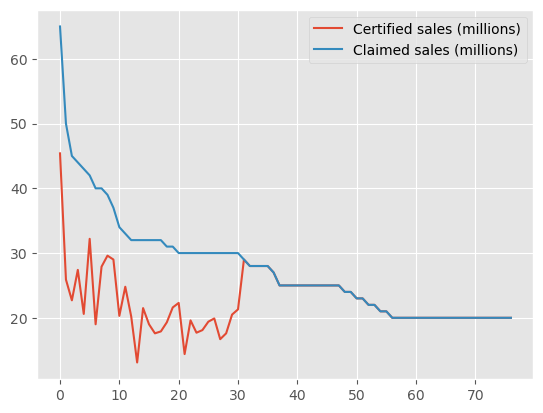

In [193]:
hit_albums.plot()
plt.show()

We can also selected certain columns using labelled indexes and then plot.

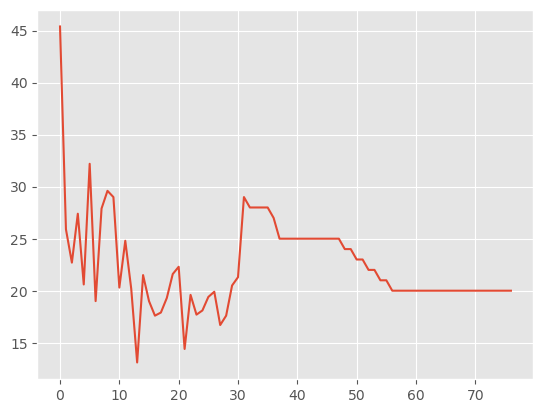

In [194]:
hit_albums["Certified sales (millions)"].plot()
plt.show()

We can also use bar-charts instead of line-charts:

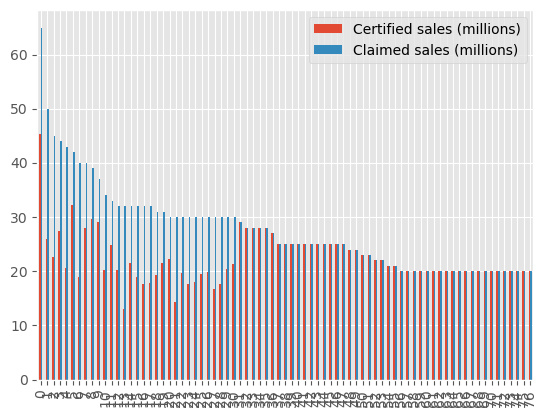

In [195]:
hit_albums[["Certified sales (millions)", "Claimed sales (millions)"]].plot(kind="bar")
plt.show()

The default is a line chart. This doesn't make much sense, since it's mixing index of the row with sales. We're better off plotting only the two different sales figures.

A better way to compare certified and claimed sales is a scatterplot:

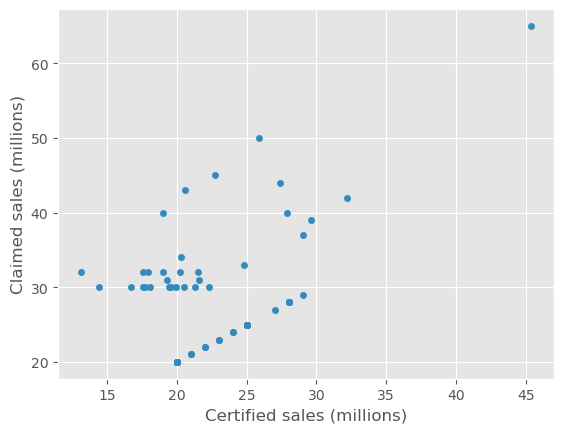

In [196]:
hit_albums.plot.scatter(x="Certified sales (millions)", y="Claimed sales (millions)")
plt.show()

Or a histogram: 

In [197]:
hit_albums.plot.hist(bins=12, alpha=0.5)
plt.show()

TypeError: no numeric data to plot

No numeric data to plot??

Time to check the dtypes:

In [ ]:
hit_albums.dtypes

In this case, we know our sales columns are numeric because we inspected them all earlier. Thus, we can do the conversion.

In [ ]:
hit_albums['Certified sales (millions)']=hit_albums['Certified sales (millions)'].astype(float)
hit_albums['Claimed sales (millions)']=hit_albums['Claimed sales (millions)'].astype(float)
hit_albums.dtypes

Aaaaah, there we go!

Let's try that histogram again:

In [ ]:
hit_albums.plot.hist(bins=12, alpha=0.5)
plt.show()

We'll do more sophisticated plotting in the future! 